## LOGO Best Model: XGBoost Performance Evaluation

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7ta0n3xy because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest, f_regression
from xgboost import XGBRegressor

/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## XGBoost Model

In [3]:
# Let's load the data
df = pd.read_csv("processed_data_berlin_08042025.csv")

# And, drop stations with ≤ 2 years of data
station_years = df.groupby('station_name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df_filtered = df[df['station_name'].isin(valid_stations)].copy()

In [4]:
# SMAPE function
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

# Let's set up LOGO-CV
logo = LeaveOneGroupOut()
groups = df_filtered['station_name']

In [5]:
# Store all predictions
all_actuals, all_predictions = [], []
aadb_actual_list, aadb_pred_list, aadb_station_list = [], [], []

# Run LOGO-CV
for train_idx, test_idx in logo.split(df_filtered, groups=groups):
    train_df = df_filtered.iloc[train_idx]
    test_df = df_filtered.iloc[test_idx]
    
    # Compute mean log volume per station (baseline)
    mean_log_volume = train_df['log_cycling_volume'].mean()
    pred_log = np.full(len(test_df), mean_log_volume)
    pred = np.expm1(pred_log)

    y_true = test_df['cycling_volume'].values

    # Daily predictions
    all_actuals.extend(y_true)
    all_predictions.extend(pred)

    # AADB-level for this test station
    aadb_actual = y_true.mean()
    aadb_pred = pred.mean()
    aadb_actual_list.append(aadb_actual)
    aadb_pred_list.append(aadb_pred)
    aadb_station_list.append(test_df['station_name'].iloc[0])

In [6]:
# Define full feature list
non_features = ['station_name', 'date', 'year', 'cycling_volume', 'log_cycling_volume', 'num_motor_sources']
features = [col for col in df_filtered.columns if col not in non_features]

X = df_filtered[features]
y = df_filtered['log_cycling_volume']

In [7]:
# Base model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Sequential Forward Selection
sfs = SequentialFeatureSelector(
    xgb_model,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1
)

sfs.fit(X, y)

# Selected features
selected_features = X.columns[sfs.get_support()]
print("\nSelected features by SFS for XGBoost:")
print(selected_features.tolist())


Selected features by SFS for XGBoost:
['shops_within_0km', 'hotels_within_0km', 'education_within_2km', 'hospitals_within_0km', 'farming', 'horticulture', 'industry', 'parks', 'tavg', 'tmin', 'prcp', 'snow', 'wspd', 'wpgt', 'pres', 'tsun', 'wdir', 'avg_motor_volume', 'avg_truck_speed', 'total_motor_cars', 'total_motor_trucks', 'city_avg_truck_speed', 'city_total_motor_vehicles', 'city_total_cars', 'day_of_week', 'is_weekend', 'month', 'bicycle_lane_type_separate', 'bicycle_lane_type_sidepath', 'bicycle_lane_type_track']


In [8]:
# Use selected features
X_selected = df_filtered[selected_features]
y = df_filtered['log_cycling_volume']

# Parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5],
    'gamma': [0, 1]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_selected, y)

print("\nBest hyperparameters for XGBoost:")
print(grid_search.best_params_)

# Store best model
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best hyperparameters for XGBoost:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


In [9]:
# Define groups
groups = df_filtered['station_name']
logo = LeaveOneGroupOut()

In [10]:
# Storage
all_preds, all_true = [], []
aadb_preds, aadb_actuals, aadb_stations = [], [], []
station_wise_preds = []  # To store true and pred per station

# LOGO Loop
for train_idx, test_idx in logo.split(df_filtered, groups=groups):
    train_df = df_filtered.iloc[train_idx]
    test_df = df_filtered.iloc[test_idx]

    X_train = train_df[selected_features]
    y_train = train_df['log_cycling_volume']
    X_test = test_df[selected_features]
    y_test_true = test_df['cycling_volume']

    model = XGBRegressor(**grid_search.best_params_, objective='reg:squarederror', random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    all_preds.extend(y_pred)
    all_true.extend(y_test_true.values)

    aadb_preds.append(np.mean(y_pred))
    aadb_actuals.append(np.mean(y_test_true.values))
    aadb_stations.append(test_df['station_name'].iloc[0])

    temp_df = pd.DataFrame({
        'station_name': test_df['station_name'].values,
        'true_volume': y_test_true.values,
        'predicted_volume': y_pred
    })
    station_wise_preds.append(temp_df)

In [11]:
# SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

# Daily metrics
mae_daily = mean_absolute_error(all_true, all_preds)
rmse_daily = np.sqrt(mean_squared_error(all_true, all_preds))
smape_daily = smape(np.array(all_true), np.array(all_preds))

In [12]:
# AADB metrics
aadb_df = pd.DataFrame({
    'station': aadb_stations,
    'actual': aadb_actuals,
    'predicted': aadb_preds
})

mae_aadb = mean_absolute_error(aadb_df['actual'], aadb_df['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_df['actual'], aadb_df['predicted']))
smape_aadb = smape(aadb_df['actual'], aadb_df['predicted'])

In [13]:
# Output
print("\nLOGO XGBoost Evaluation:")
print(f"Daily  → MAE: {mae_daily:.2f}, RMSE: {rmse_daily:.2f}, SMAPE: {smape_daily:.2f}%")
print(f"AADB   → MAE: {mae_aadb:.2f}, RMSE: {rmse_aadb:.2f}, SMAPE: {smape_aadb:.2f}%")


LOGO XGBoost Evaluation:
Daily  → MAE: 1366.49, RMSE: 2048.08, SMAPE: 45.01%
AADB   → MAE: 1152.88, RMSE: 1465.96, SMAPE: 38.69%


## Station-level Error Analysis

In [14]:
plt.rcParams.update({'font.weight': 'bold',
                     'axes.labelweight': 'bold',
                     'axes.titleweight': 'bold',
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'x-large'})

In [15]:
station_preds_df = pd.concat(station_wise_preds, axis=0)

station_error = station_preds_df.groupby('station_name').apply(
    lambda group: pd.Series({
        'MAE': mean_absolute_error(group['true_volume'], group['predicted_volume']),
        'RMSE': np.sqrt(mean_squared_error(group['true_volume'], group['predicted_volume'])),
        'SMAPE': smape(group['true_volume'].values, group['predicted_volume'].values)
    })
).reset_index()

print("\nStation-Level Errors (Berlin):")
print(station_error)


Station-Level Errors (Berlin):
              station_name          MAE         RMSE      SMAPE
0           Alberichstraße   888.486568  1008.892733  93.332145
1          Berliner Straße  2356.199220  2746.731751  51.235923
2         Breitenbachplatz  1125.849875  1365.461843  55.923317
3        Frankfurter Allee  1705.603295  2304.106966  32.726553
4          Invalidenstraße   878.680023  1140.505711  24.073369
5          Jannowitzbrücke  3573.008597  4183.242011  55.809971
6               Kaisersteg   288.377163   413.148643  24.515427
7            Klosterstraße   318.047171   445.041122  18.975398
8        Mariendorfer Damm   253.584556   336.522503  23.097946
9               Markstraße  1078.087796  1221.026568  61.098677
10             Maybachufer  2171.534077  2397.783617  63.311995
11        Monumentenstraße   638.825986   843.203487  17.918485
12          Oberbaumbrücke  4488.212832  5006.459473  83.068924
13  Paul-und-Paula-Uferweg   727.291586   987.482392  28.552577
14     P

<ipython-input-16-7dbfd84a118b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


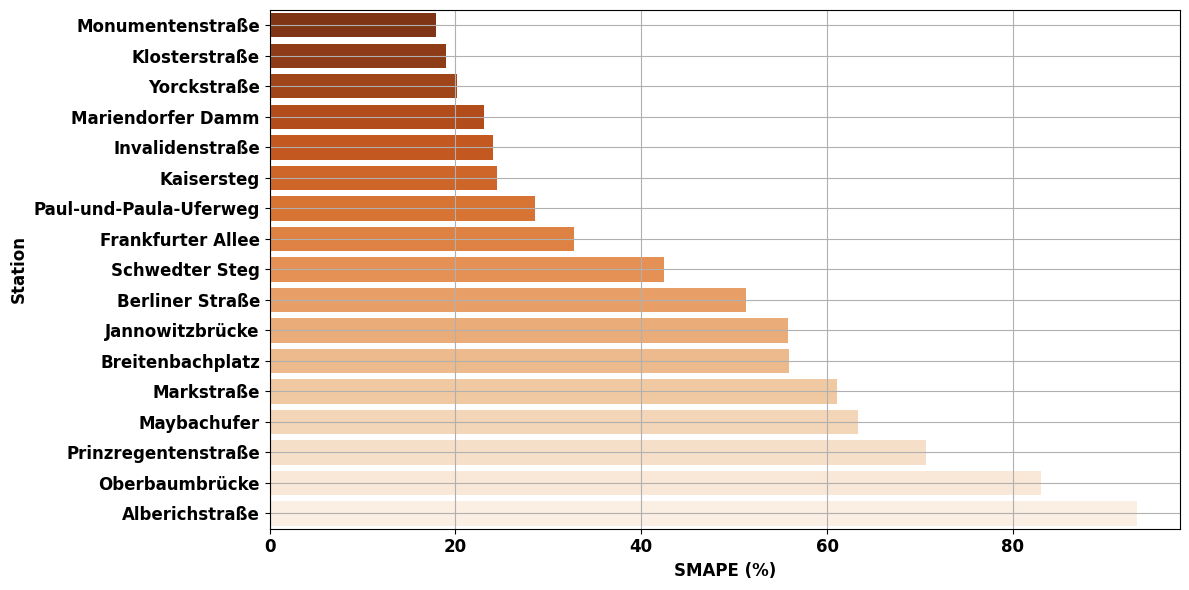

In [16]:
# Plot station-level SMAPE at daily level
plt.figure(figsize=(12, 6))
sns.barplot(
    data=station_error.sort_values('SMAPE'),
    x='SMAPE',
    y='station_name',
    palette='Oranges_r'
)
plt.xlabel('SMAPE (%)')
plt.ylabel('Station')
#plt.title('Station-wise SMAPE - XGBoost (LOGO-CV)')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-17-ff575c963465>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


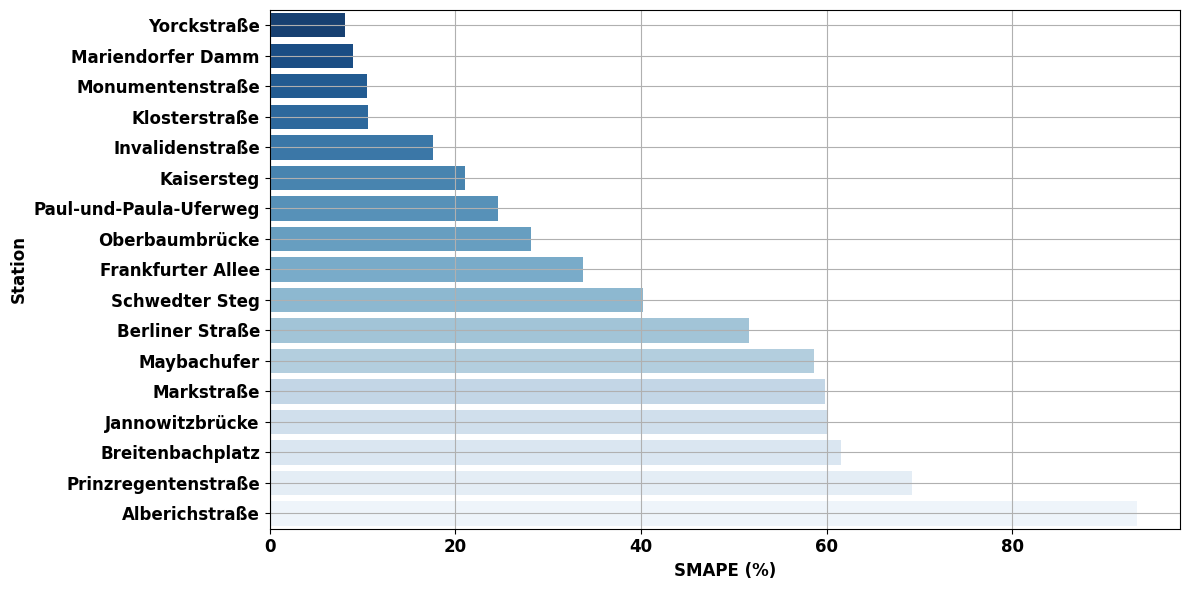

In [17]:
aadb_df['SMAPE'] = 2 * np.abs(aadb_df['predicted'] - aadb_df['actual']) / (np.abs(aadb_df['actual']) + np.abs(aadb_df['predicted'])) * 100

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=aadb_df.sort_values('SMAPE'),
    x='SMAPE',
    y='station',
    palette='Blues_r'
)
plt.xlabel('SMAPE (%)')
plt.ylabel('Station')
#plt.title('Station-wise SMAPE - XGBoost (AADB Level)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance Analysis

In [18]:
# Feature Importance from the best trained XGBoost model
importances = best_xgb_model.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

<ipython-input-19-d32f40347edc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


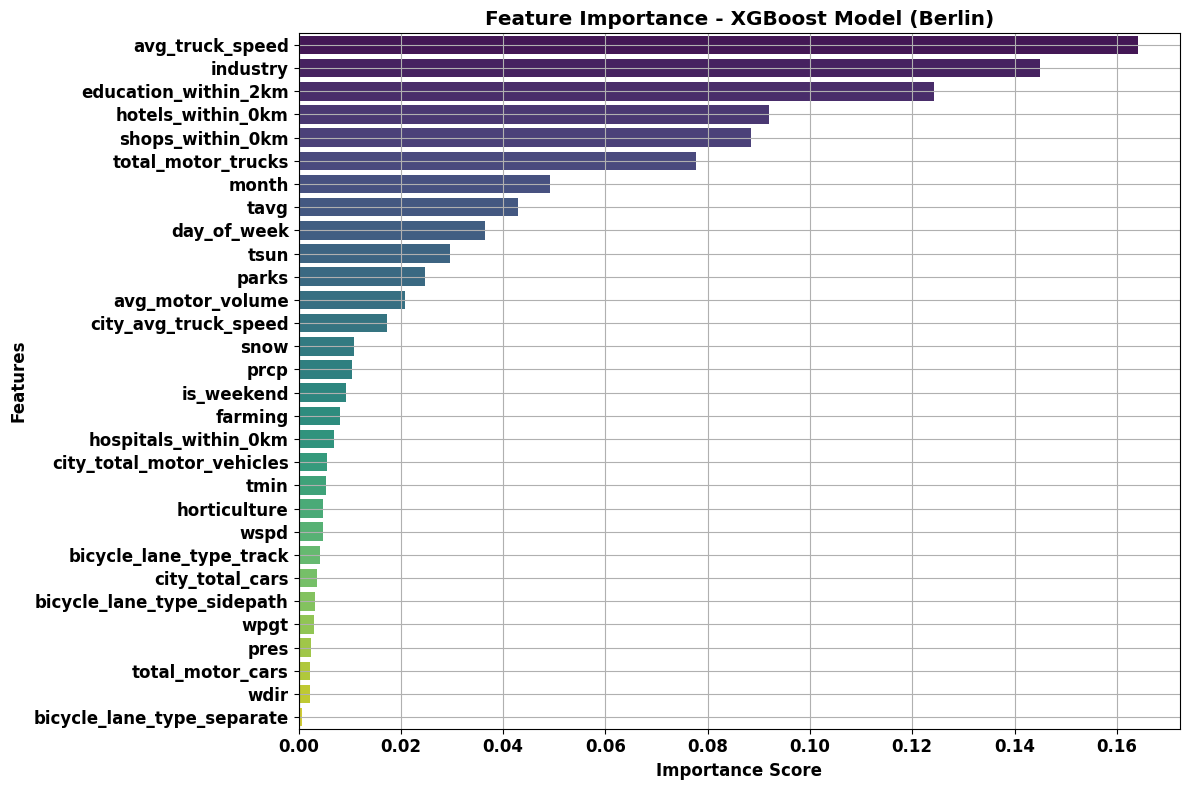

In [19]:
# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - XGBoost Model (Berlin)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.tight_layout()
plt.show()

## Grouped Feature Importance

In [20]:
feature_groups = {
    'Weather': ['tavg', 'tmin', 'prcp', 'snow', 'wspd', 'wpgt', 'pres', 'tsun', 'wdir'],
    'Temporal': ['day_of_week', 'is_weekend', 'month'],
    'Infrastructure': ['shops_within_0km', 'hotels_within_0km', 'education_within_2km', 'hospitals_within_0km', 
                       'bicycle_lane_type_separate', 'bicycle_lane_type_sidepath', 'bicycle_lane_type_track'],
    'Land Use': ['farming', 'horticulture', 'industry', 'parks'],
    'Traffic Volume': ['avg_motor_volume', 'total_motor_cars', 'total_motor_trucks', 
                       'city_total_motor_vehicles', 'city_total_cars'],
    'Traffic Speed': ['avg_truck_speed',  'city_avg_truck_speed']
}

In [21]:
# Data - use selected features
X = df_filtered[selected_features]
y = df_filtered['log_cycling_volume']

# Initialize storage
kf = KFold(n_splits=5, shuffle=True, random_state=42)
group_importance_scores = {group: [] for group in feature_groups.keys()}

# Define SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(np.expm1(y_pred) - np.expm1(y_true)) / (np.abs(np.expm1(y_true)) + np.abs(np.expm1(y_pred)))
    )

In [22]:
# Loop over folds
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model
    model = XGBRegressor(**grid_search.best_params_, objective='reg:squarederror', random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Baseline error (on clean validation set)
    y_pred_base = model.predict(X_val)
    base_error = smape(y_val, y_pred_base)

    # Now for each feature group:
    for group_name, group_features in feature_groups.items():
        X_val_permuted = X_val.copy()

        # Permute all features in the group
        for feature in group_features:
            if feature in X_val.columns:
                X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature].values)

        # Predict with permuted features
        y_pred_permuted = model.predict(X_val_permuted)
        permuted_error = smape(y_val, y_pred_permuted)

        # Importance = increase in error
        importance_score = permuted_error - base_error
        group_importance_scores[group_name].append(importance_score)


<ipython-input-23-aad67f0f54e8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df.index, palette='Set2')


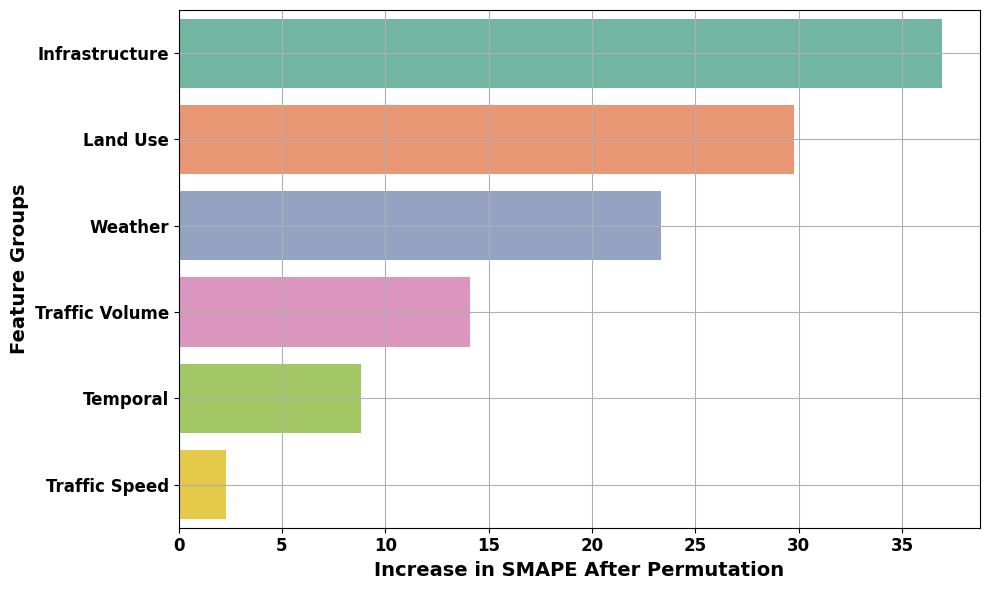

In [23]:
# Final importance by averaging across folds
group_importance_means = {group: np.mean(scores) for group, scores in group_importance_scores.items()}

# Create DataFrame for plotting
importance_df = pd.DataFrame.from_dict(group_importance_means, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df.index, palette='Set2')
plt.xlabel('Increase in SMAPE After Permutation', fontsize=14)
plt.ylabel('Feature Groups', fontsize=14)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()